# Análises para o banner

# Analisando a série de retornos

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emd
from scipy.signal import hilbert

## Carregando os dados do IMEA - Soja Sorriso-MT

In [101]:
# Link da planilha
url = r"https://docs.google.com/spreadsheets/d/e/2PACX-1vTAoXtb7h8rzJl3A_fwWc2GgnN6DTyoj6QhMfrAVY3uETpo2HmDbjmdJRRZLccwcA/pub?output=xlsx"

sorriso = pd.read_excel(url)
sorriso.head(3)

Cidade       Data       Valor         Unidade
0  Sorriso 2021-01-11  151.193366  Reais por saca
1  Sorriso 2021-01-12  152.695531  Reais por saca
2  Sorriso 2021-01-13  148.774896  Reais por saca

## Tratando as colunas

In [102]:
sorriso.drop(columns=['Cidade', 'Unidade'], axis=1, inplace=True)
sorriso.set_index('Data', inplace=True)
sorriso['Retornos'] = sorriso['Valor'].pct_change()
sorriso.dropna(subset=['Retornos'], inplace=True)
sorriso.head(2)

Valor  Retornos
Data                            
2021-01-12  152.695531  0.009935
2021-01-13  148.774896 -0.025676

## Plot dos preços

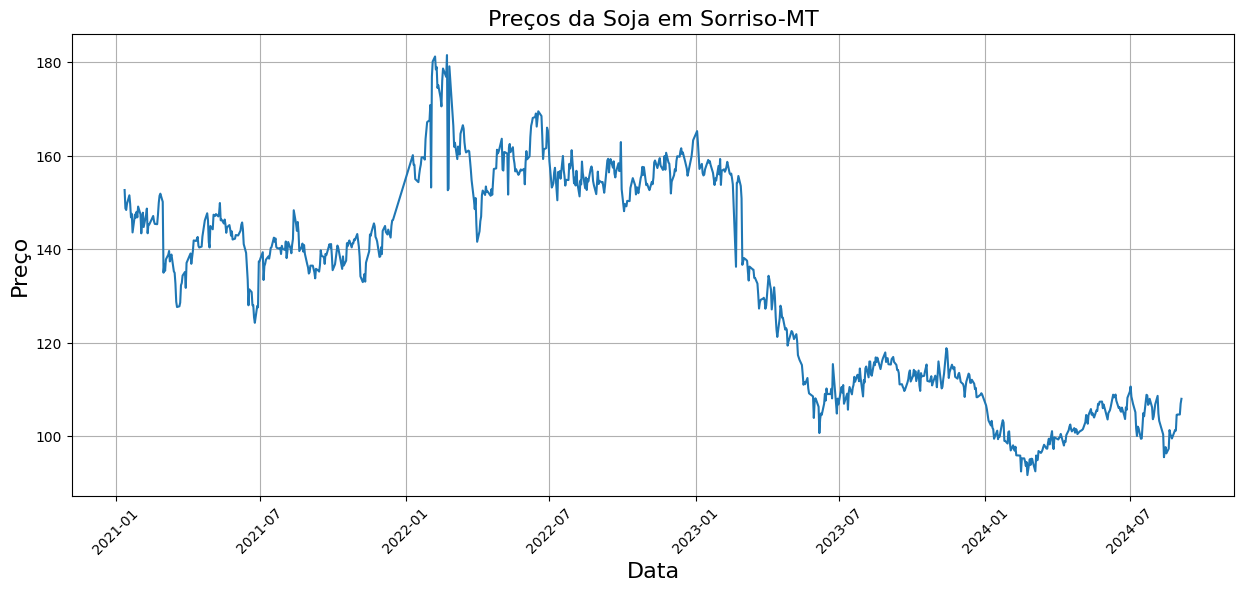

In [103]:
plt.figure(figsize=(15,6))
plt.plot(sorriso['Valor'])
plt.title('Preços da Soja em Sorriso-MT', fontsize=16)
plt.xlabel('Data', fontsize=16)
plt.ylabel('Preço', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Plot dos retornos

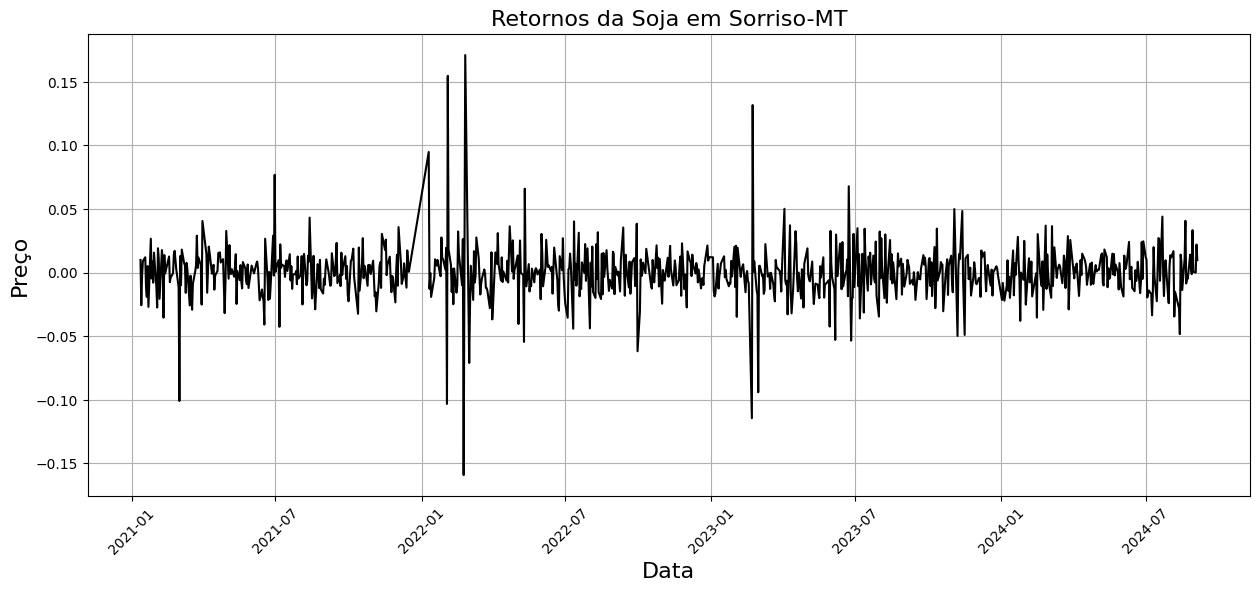

In [104]:
plt.figure(figsize=(15,6))
plt.plot(sorriso['Retornos'], color='black')
plt.title('Retornos da Soja em Sorriso-MT', fontsize=16)
plt.xlabel('Data', fontsize=16)
plt.ylabel('Preço', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Hilbert-Huang - Retornos
Gerar a segunda IMF

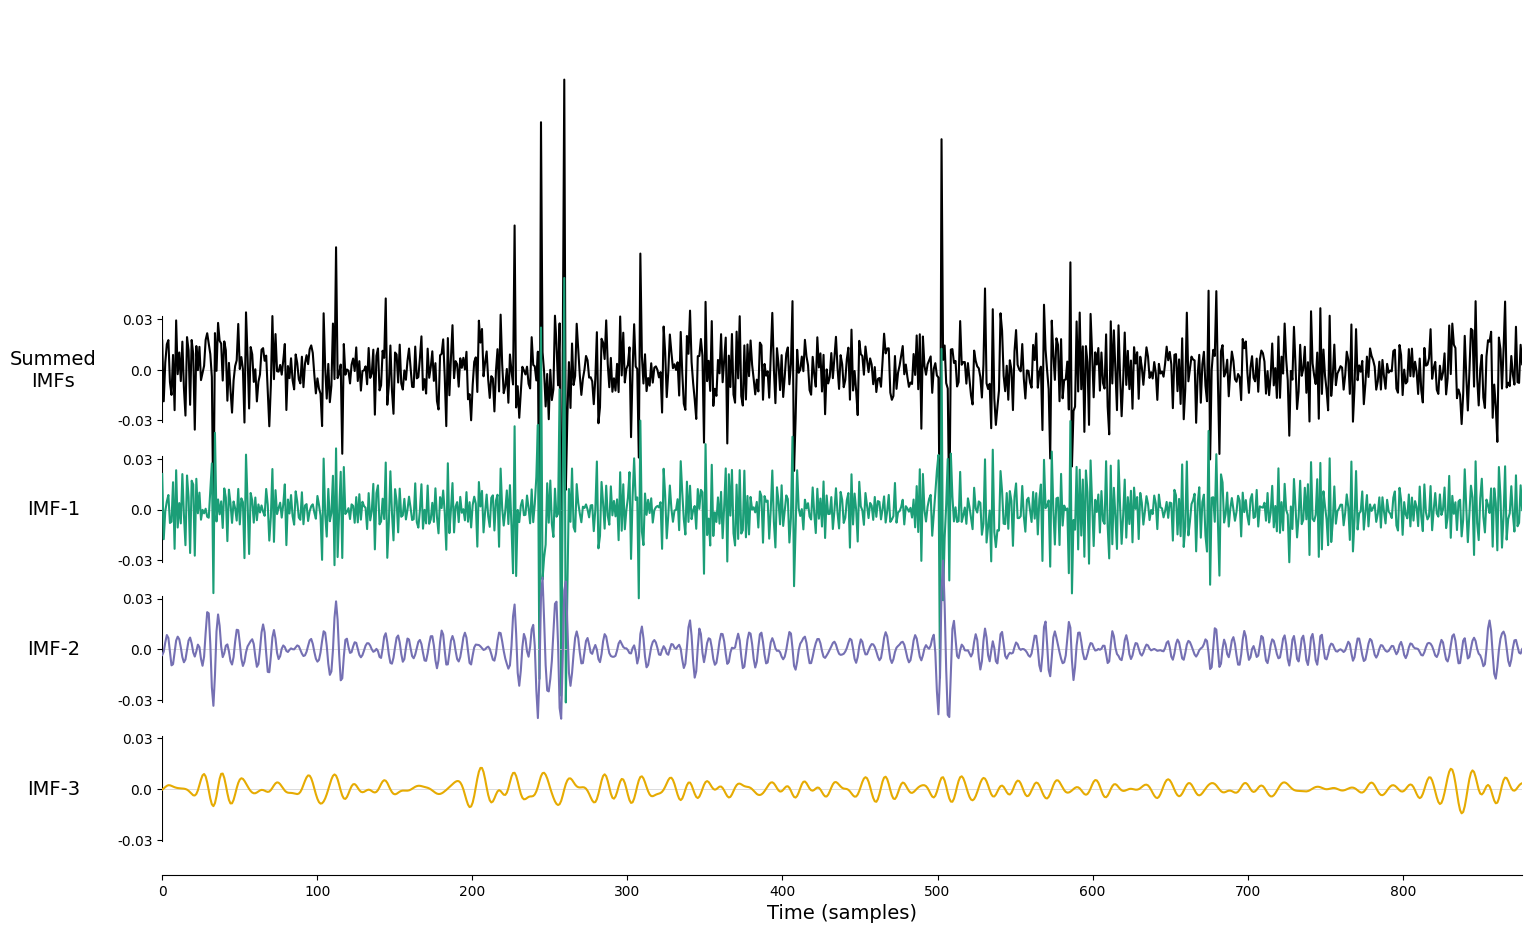

In [105]:
retornos = np.array(sorriso['Retornos'])
imf = emd.sift.mask_sift(retornos, max_imfs=3)

emd.plotting.plot_imfs(imf)
plt.show()

In [106]:
def plot_fasesHH(serie, n_imf=0):
    '''Plota as fases de uma Transformada de Hilbert-Huang
    serie: Uma série temporal
    n_imf: número da imf que será plotada
    '''

    imf = emd.sift.mask_sift(serie, max_imfs=5)

    #IP: Fase Instantânea, IF: Frequência instantânea, IA: Amplitude Instantânea
    IP, IF, IA = emd.spectra.frequency_transform(imf, len(serie), 'nht')

    IPn_unwrapped = np.unwrap(IP[:, n_imf])

    #### PLOT ######
    plt.figure(figsize=(15, 18))

    # Primeiro subplot - IMF-N
    plt.subplot(3, 1, 1)
    plt.plot(imf[:, n_imf], color='black')
    plt.title(f'IMF-{n_imf+1}', fontsize=16)
    plt.xticks(rotation=45)
    plt.grid(True)

    # Segundo subplot - Fase IMF-N
    plt.subplot(3, 1, 2)
    plt.plot(IP[:, n_imf])
    plt.title(f'Fase IMF-{n_imf+1} - Hilbert-Huang', fontsize=16)
    plt.ylabel('Fase', fontsize=16)
    plt.xticks(rotation=45)
    plt.grid(True)

    # Terceiro subplot - Fase desenrolada IMF-N
    plt.subplot(3, 1, 3)
    plt.plot(IPn_unwrapped)
    plt.title(f'Fase desenrolada IMF-{n_imf+1} - Hilbert-Huang', fontsize=16)
    plt.xlabel('Amostras', fontsize=16)
    plt.ylabel('Fase', fontsize=16)
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()

    return IP[:, n_imf], IPn_unwrapped

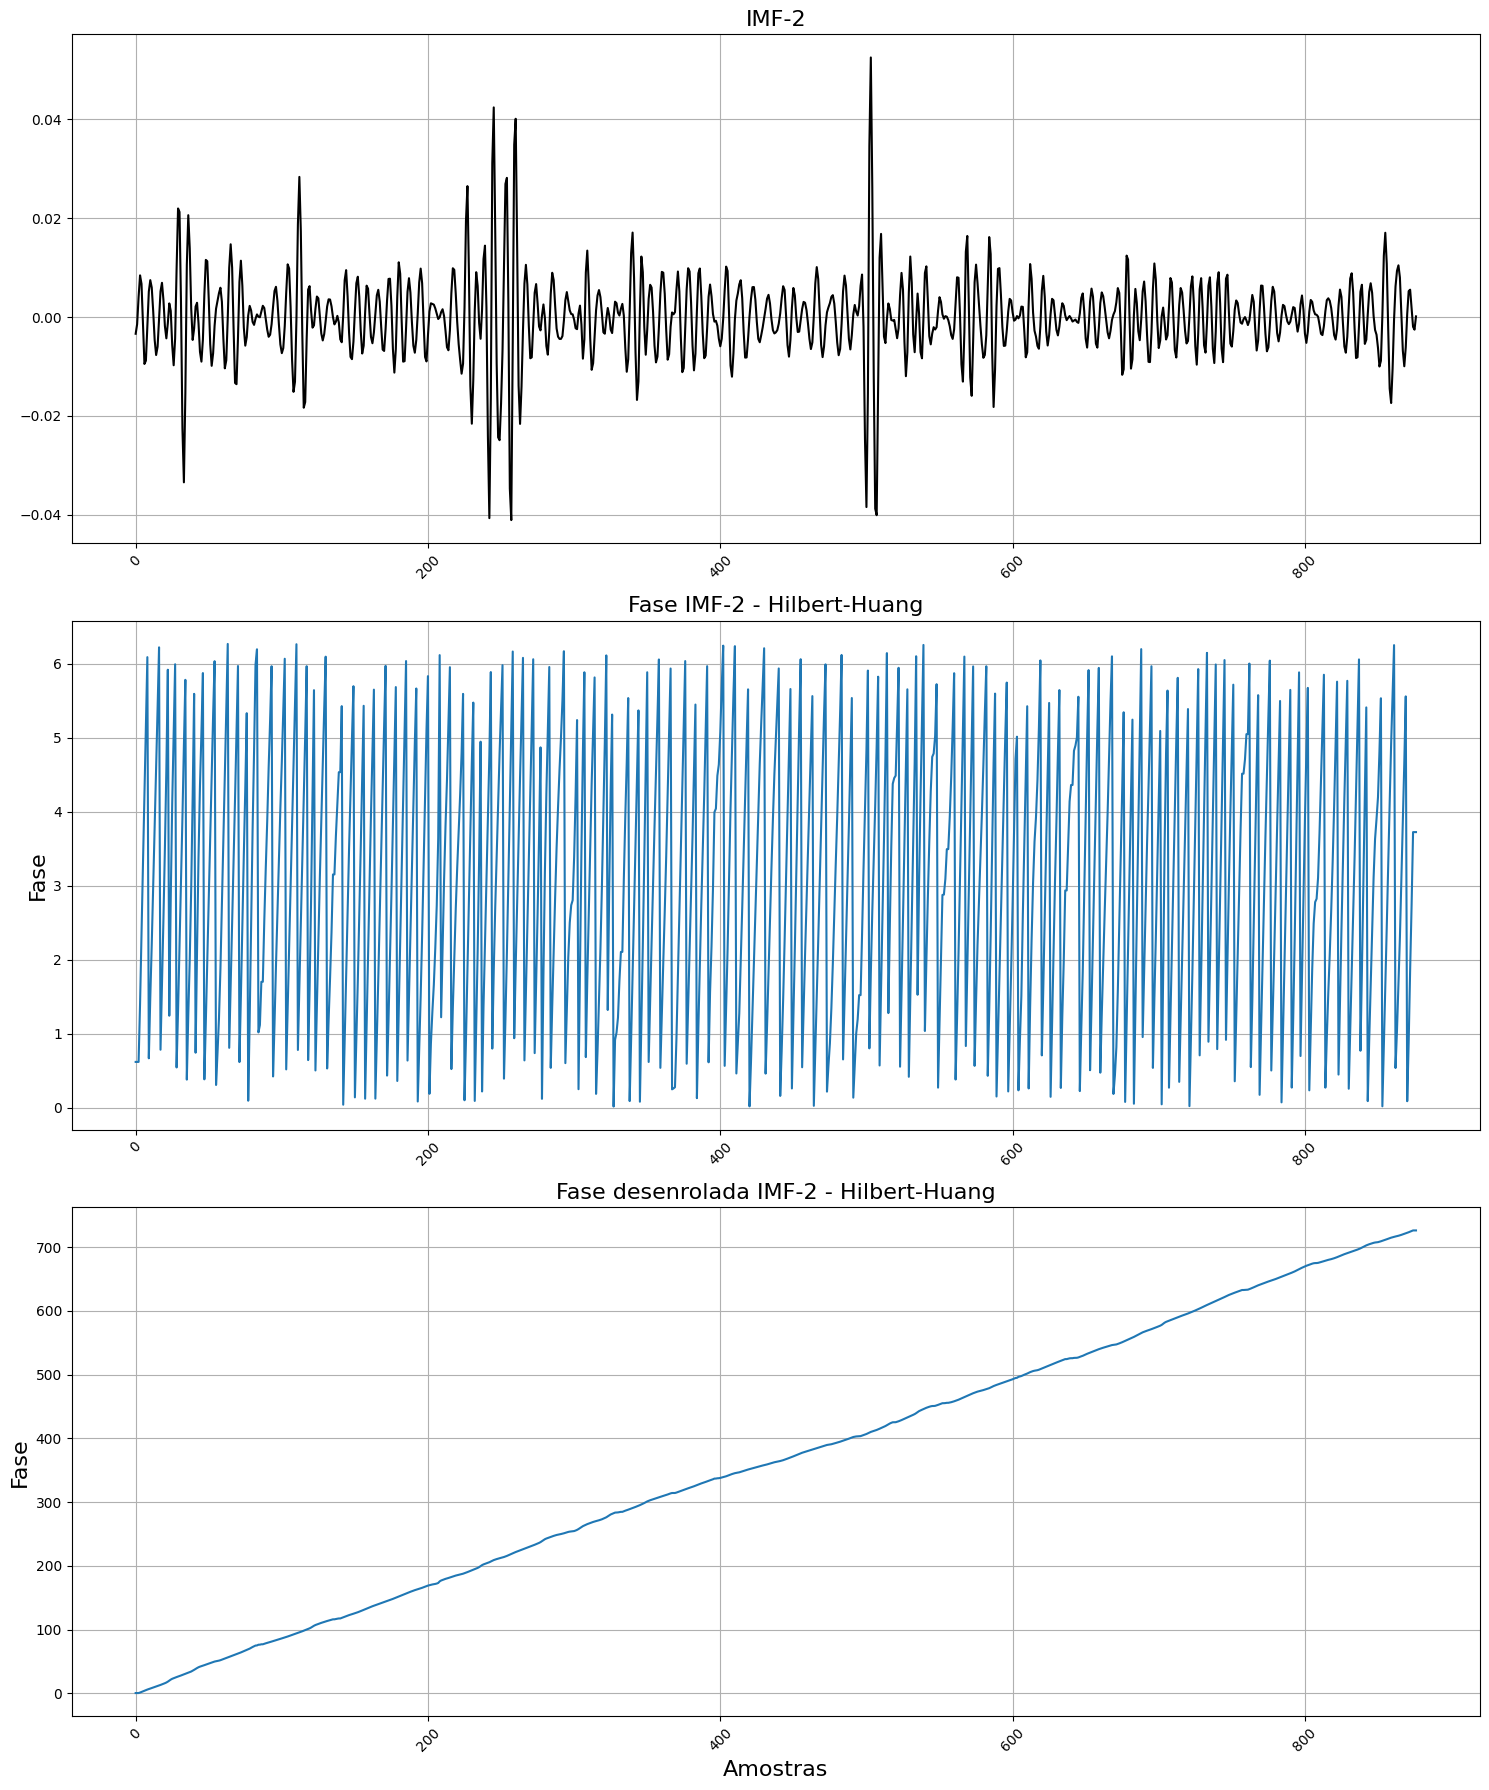

In [107]:
fase_ret_HH, fase_unwrapped_ret_HH = plot_fasesHH(retornos, 1)

### Fourier - Retornos

In [108]:
def plot_fasesF(serie):
    '''
    Plota as fases de Fourier de uma série temporal
    serie: Série temporal
    '''

    # Calcular a Transformada de Fourier
    n = len(serie)
    z = np.fft.fft(serie)
    freq = np.fft.fftfreq(n)

    # Zerar os valores com frequência negativa (apenas para considerar a parte positiva)
    z[freq < 0] = 0

    # Calcular a Transformada Inversa de Fourier
    w = np.fft.ifft(z)

    fase_fourier = np.angle(w)

    fase_unwrapped_fourier = np.unwrap(fase_fourier)

    ###### PLOT ######

    plt.figure(figsize=(15, 18))

    # Primeiro subplot - Série
    plt.subplot(3, 1, 1)
    plt.plot(serie, color='black')
    plt.xticks(rotation=45)
    plt.grid(True)

    # Segundo subplot - Fase Fourier
    plt.subplot(3, 1, 2)
    plt.plot(fase_fourier)
    plt.title('Fase Fourier', fontsize=16)
    plt.ylabel('Fase', fontsize=16)
    plt.xticks(rotation=45)
    plt.grid(True)

    # Terceiro subplot - Fase desenrolada Fourier
    plt.subplot(3, 1, 3)
    plt.plot(fase_unwrapped_fourier)
    plt.title('Fase desenrolada Retornos Fourier', fontsize=16)
    plt.xlabel('Amostras', fontsize=16)
    plt.ylabel('Fase', fontsize=16)
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()

    return fase_fourier, fase_unwrapped_fourier

### Plot das fases de Fourier

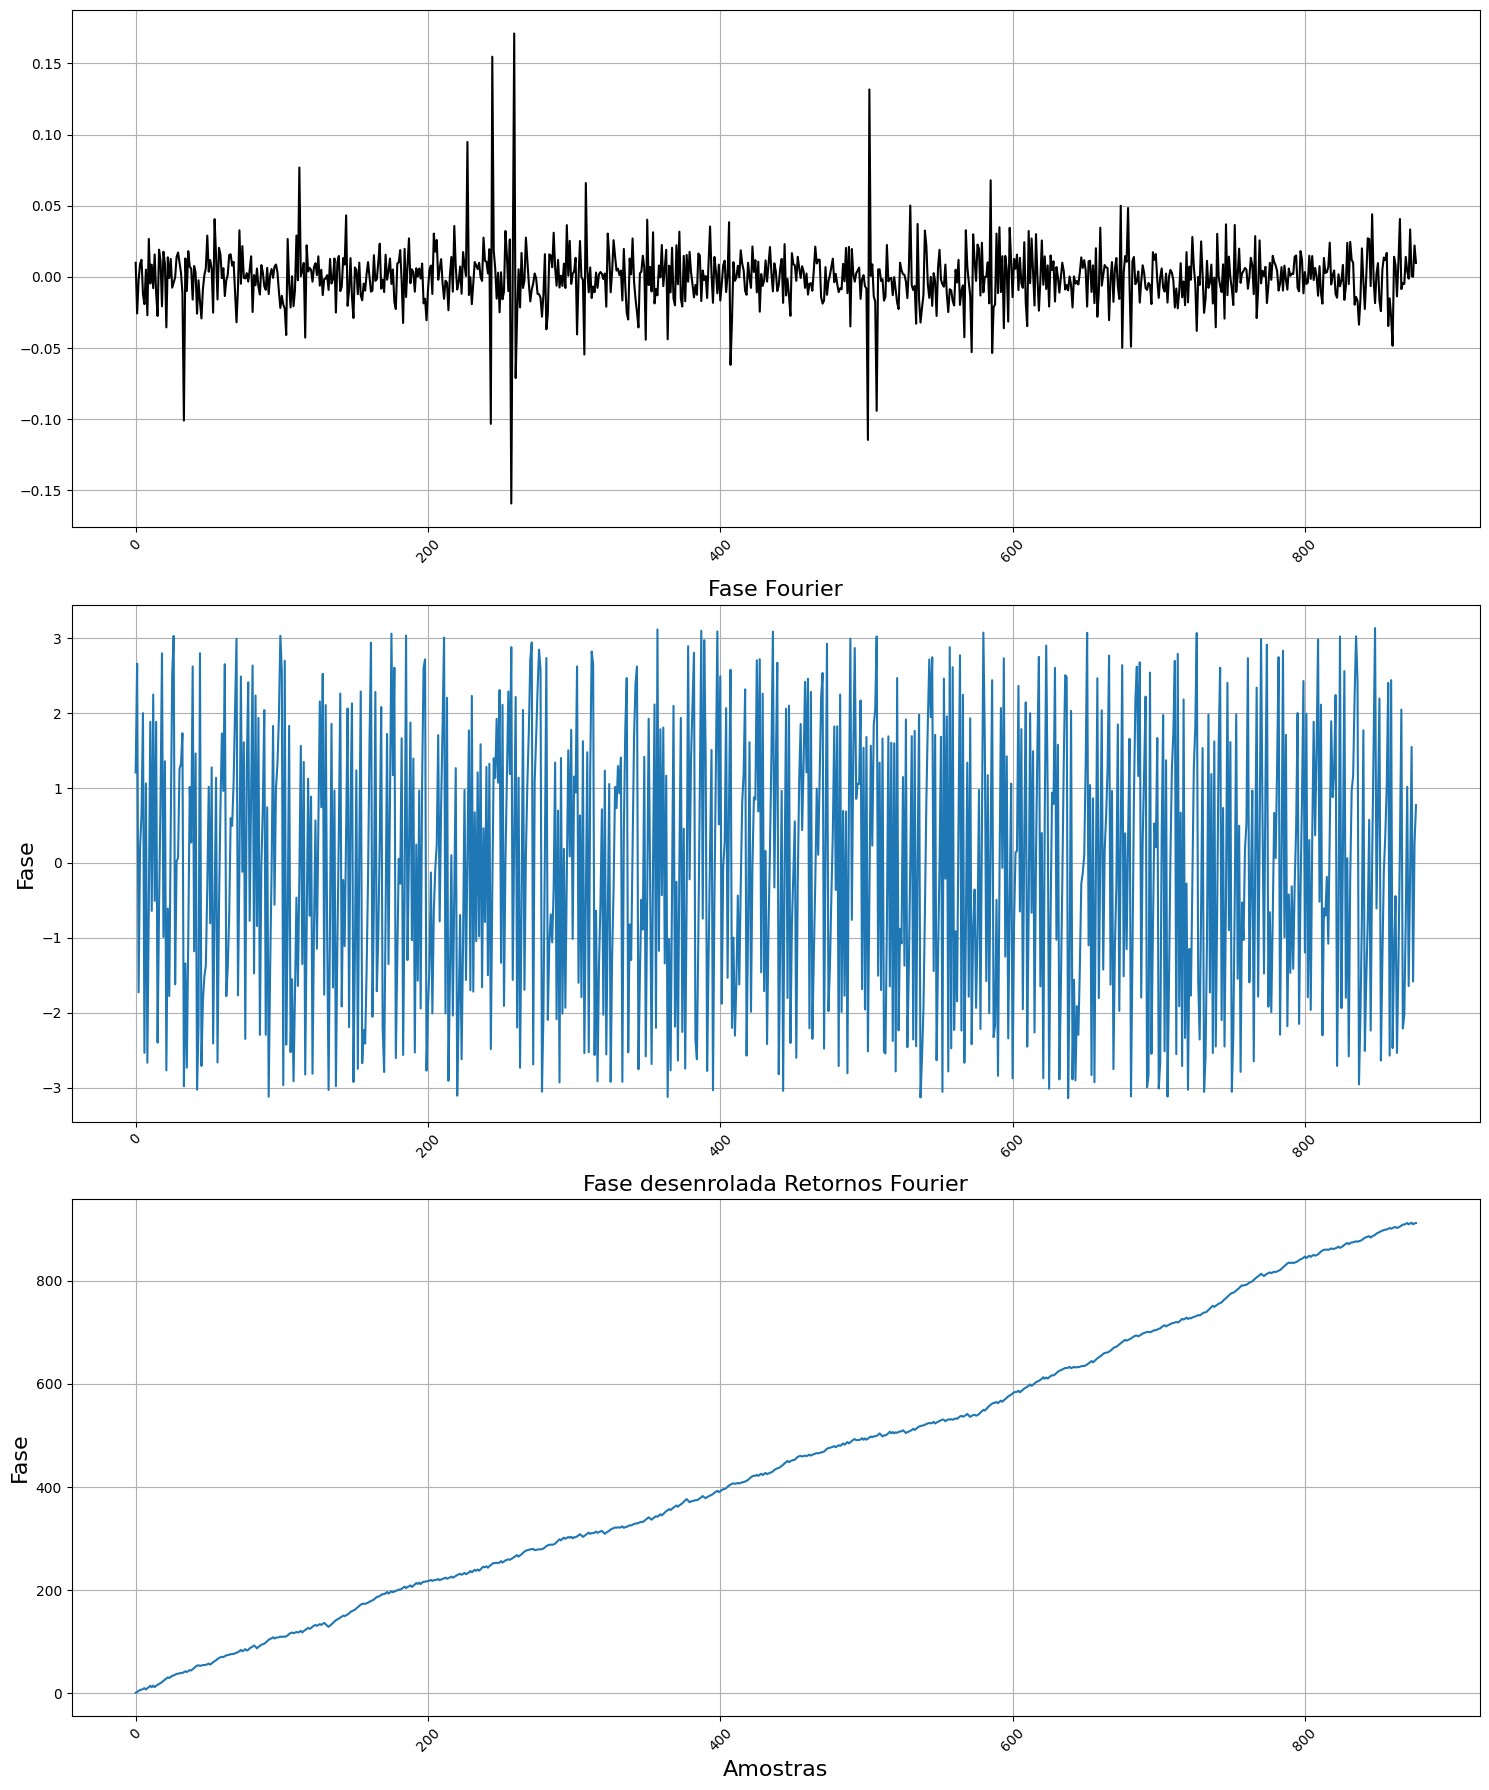

In [109]:
fase_ret_F, fase_unwrapped_ret_F = plot_fasesF(retornos)

### Hilbert - Retornos

In [110]:
def plot_fasesH(serie):
    ''' Plota as fases de Hilbert de uma série temporal'''
    sinal = hilbert(serie)
    fase_hilbert = np.angle(sinal)
    fase_unwrapped_hilbert = np.unwrap(fase_hilbert)

    ##### PLOT ######

    plt.figure(figsize=(15, 18))

    # Primeiro subplot - Série
    plt.subplot(3, 1, 1)
    plt.plot(serie, color='black')
    plt.xticks(rotation=45)
    plt.grid(True)

    # Segundo subplot - Fase Hilbert
    plt.subplot(3, 1, 2)
    plt.plot(fase_hilbert)
    plt.title('Fase Hilbert', fontsize=16)
    plt.ylabel('Fase', fontsize=16)
    plt.xticks(rotation=45)
    plt.grid(True)

    # Terceiro subplot - Fase desenrolada Hilbert
    plt.subplot(3, 1, 3)
    plt.plot(fase_unwrapped_hilbert)
    plt.title('Fase desenrolada Retornos Hilbert', fontsize=16)
    plt.xlabel('Amostras', fontsize=16)
    plt.ylabel('Fase', fontsize=16)
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()

    return fase_hilbert, fase_unwrapped_hilbert

### Plot das fases de Hilbert

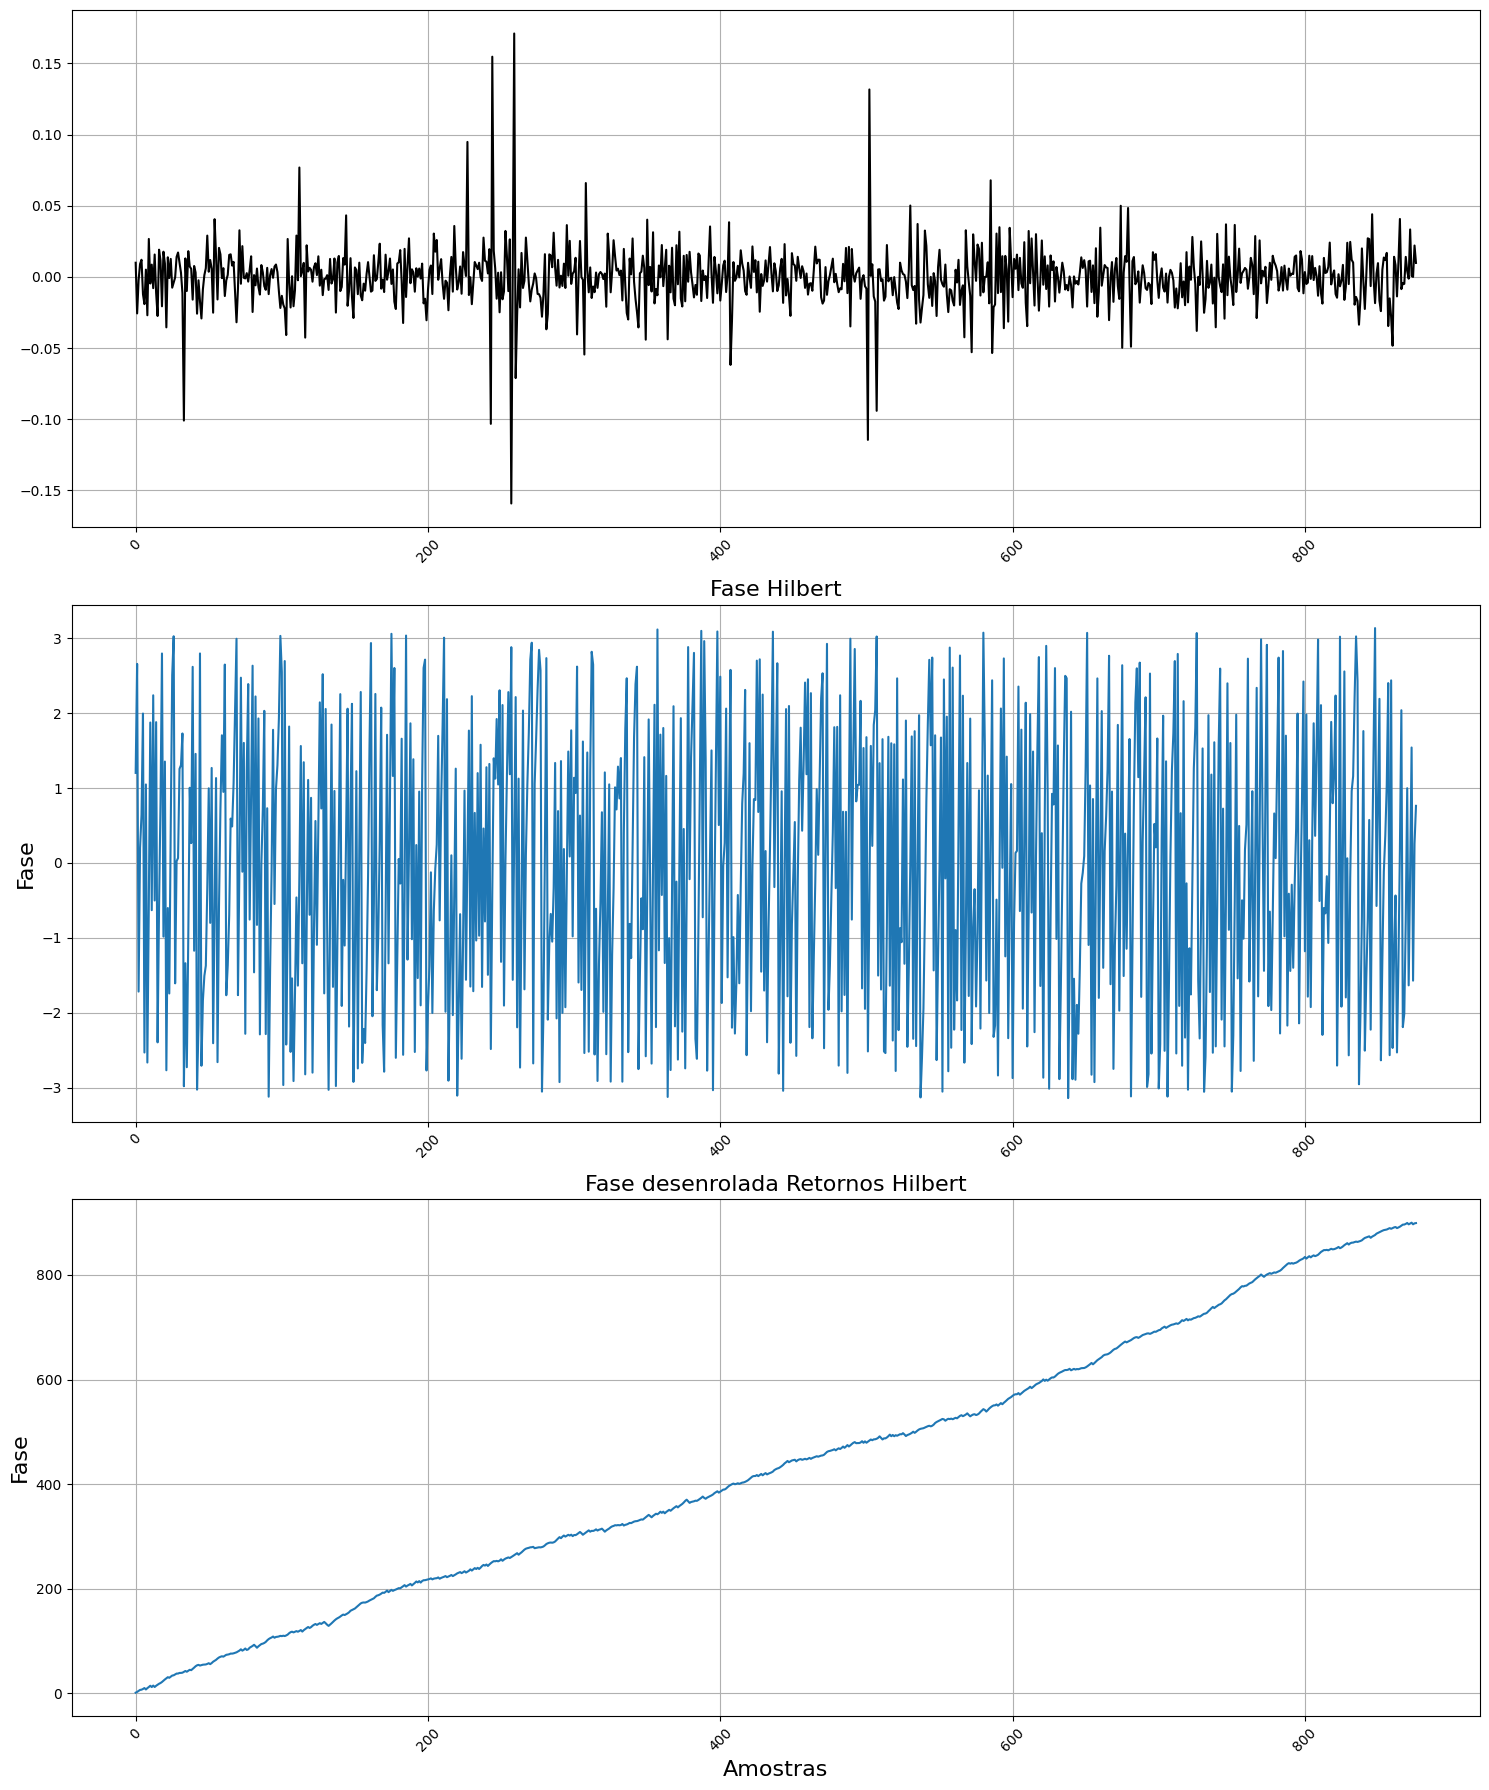

In [111]:
fase_ret_H, fase_unwrapped_ret_H = plot_fasesH(retornos)

## Comparando as fases nas 3 transformadas

In [112]:
def plot_ComparaFaseTransformadas(faseHH, unwrapHH, faseF, unwrapF, faseH, unwrapH):
    ''' Compara as Fases das Transformadas de Hilbert-Huang, Fourier e Hilbert
    faseHH --> Array com as fases de Hilbert-Huang
    unwrapHH --> Array com a fase desenrolada de Hilbert-Huang
    faseF --> Array com as fases de Fourier
    unwrapF --> Array com a fase desenrolada de Fourier
    faseH --> Array com as fases de Hilbert
    unwrapH --> Array com a fase desenrolada de Hilbert
    '''
    
    ####### PLOT ######

    plt.figure(figsize=(15, 12))

    # Primeiro subplot - Fases
    plt.subplot(2, 1, 1)
    plt.plot(faseHH, color='black', label='Hilbert-Huang')
    plt.plot(faseF, color='red', label='Fourier')
    plt.plot(faseH, color='blue', label='Hilbert')
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(True)
    plt.title('Fases', fontsize=16)

    # Segundo subplot - Fases desenroladas
    plt.subplot(2, 1, 2)
    plt.plot(unwrapHH, color='black', label='Hilbert-Huang')
    plt.plot(unwrapF, color='red', label='Fourier')
    plt.plot(unwrapH, color='blue', label='Hilbert')
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(True)
    plt.title('Fases desenroladas', fontsize=16)

    # Ajustar o layout
    plt.tight_layout()

    plt.show()

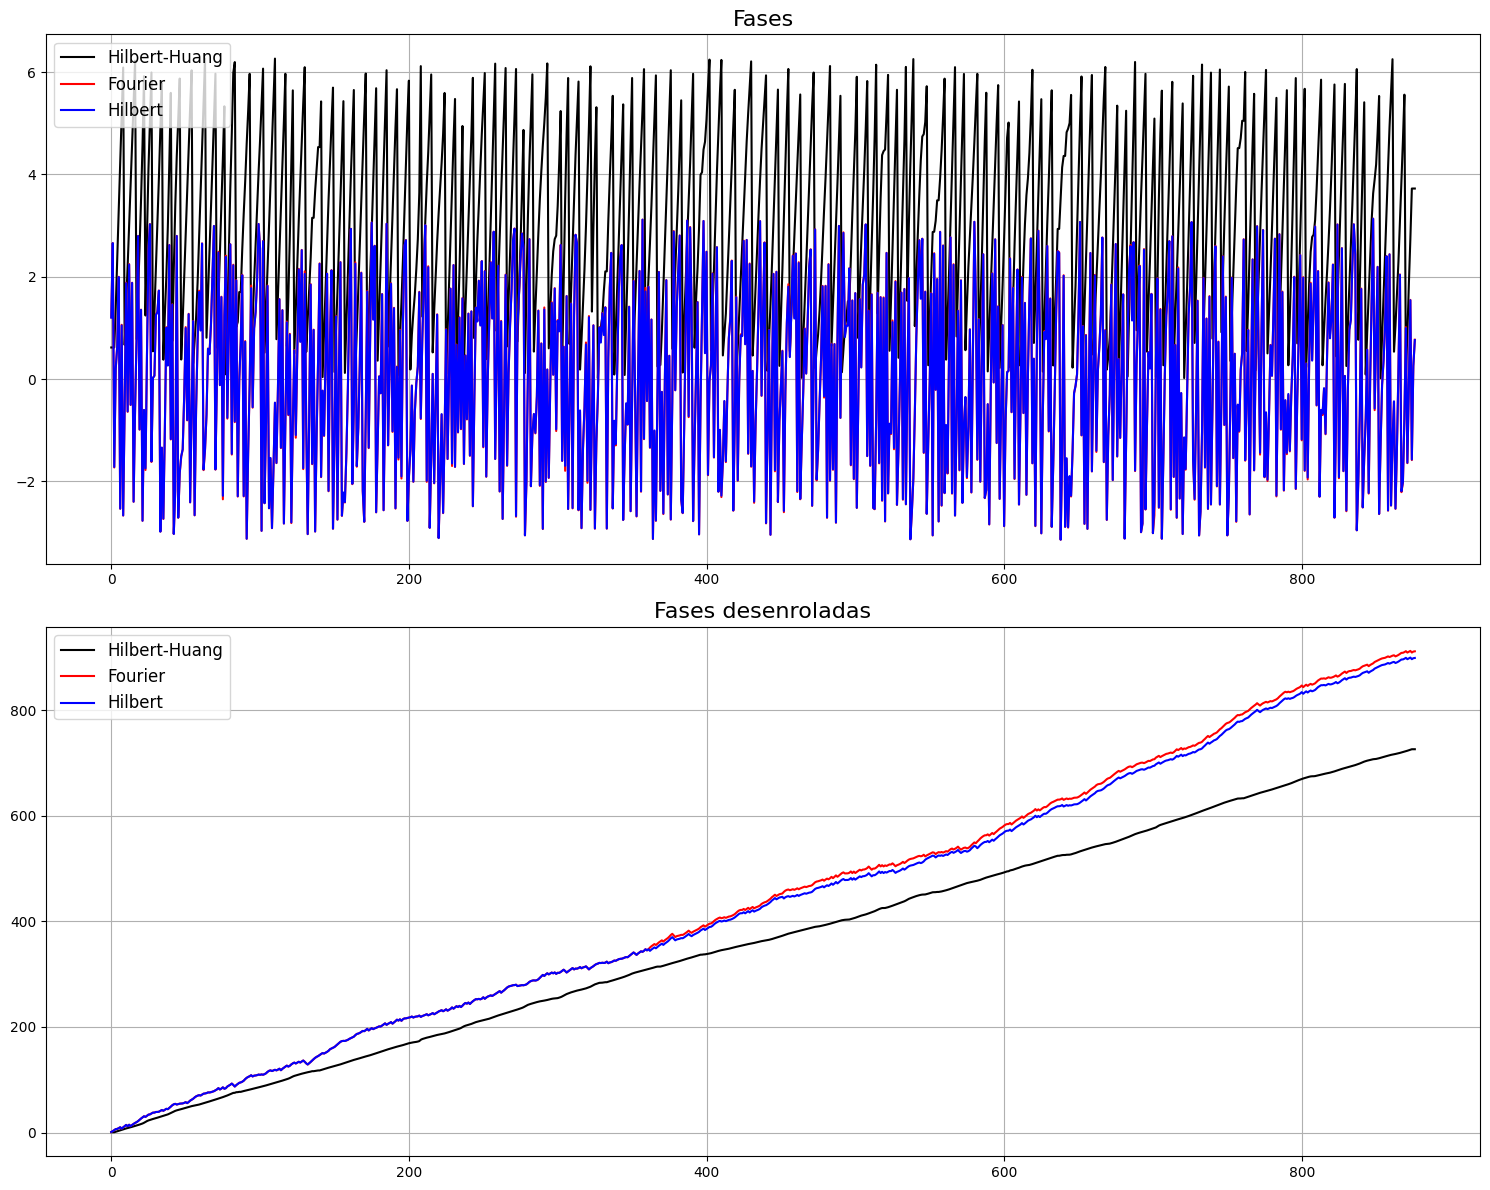

In [113]:
plot_ComparaFaseTransformadas(fase_ret_HH, 
                              fase_unwrapped_ret_HH, 
                              fase_ret_F, 
                              fase_unwrapped_ret_F,
                              fase_ret_H,
                              fase_unwrapped_ret_H)

# Analisando a série de preços

## Hilbert-Huang - Preços
Gerar a primeira IMF

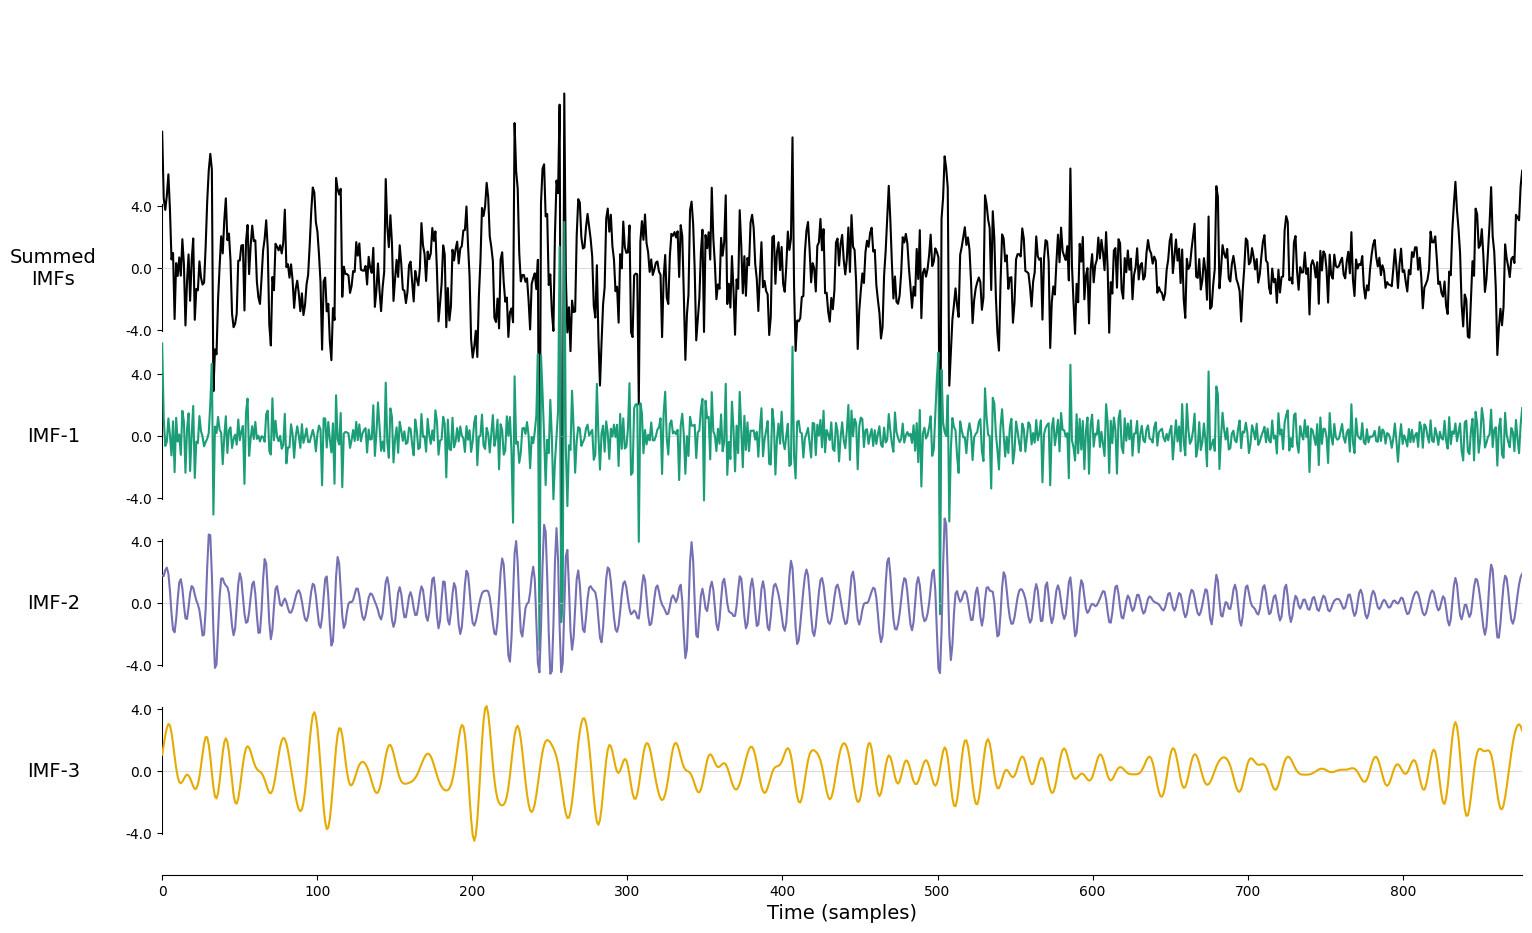

In [114]:
precos = np.array(sorriso['Valor'])
imf = emd.sift.mask_sift(precos, max_imfs=3)

emd.plotting.plot_imfs(imf)
plt.show()

### Fases Hilbert-Huang - Preços

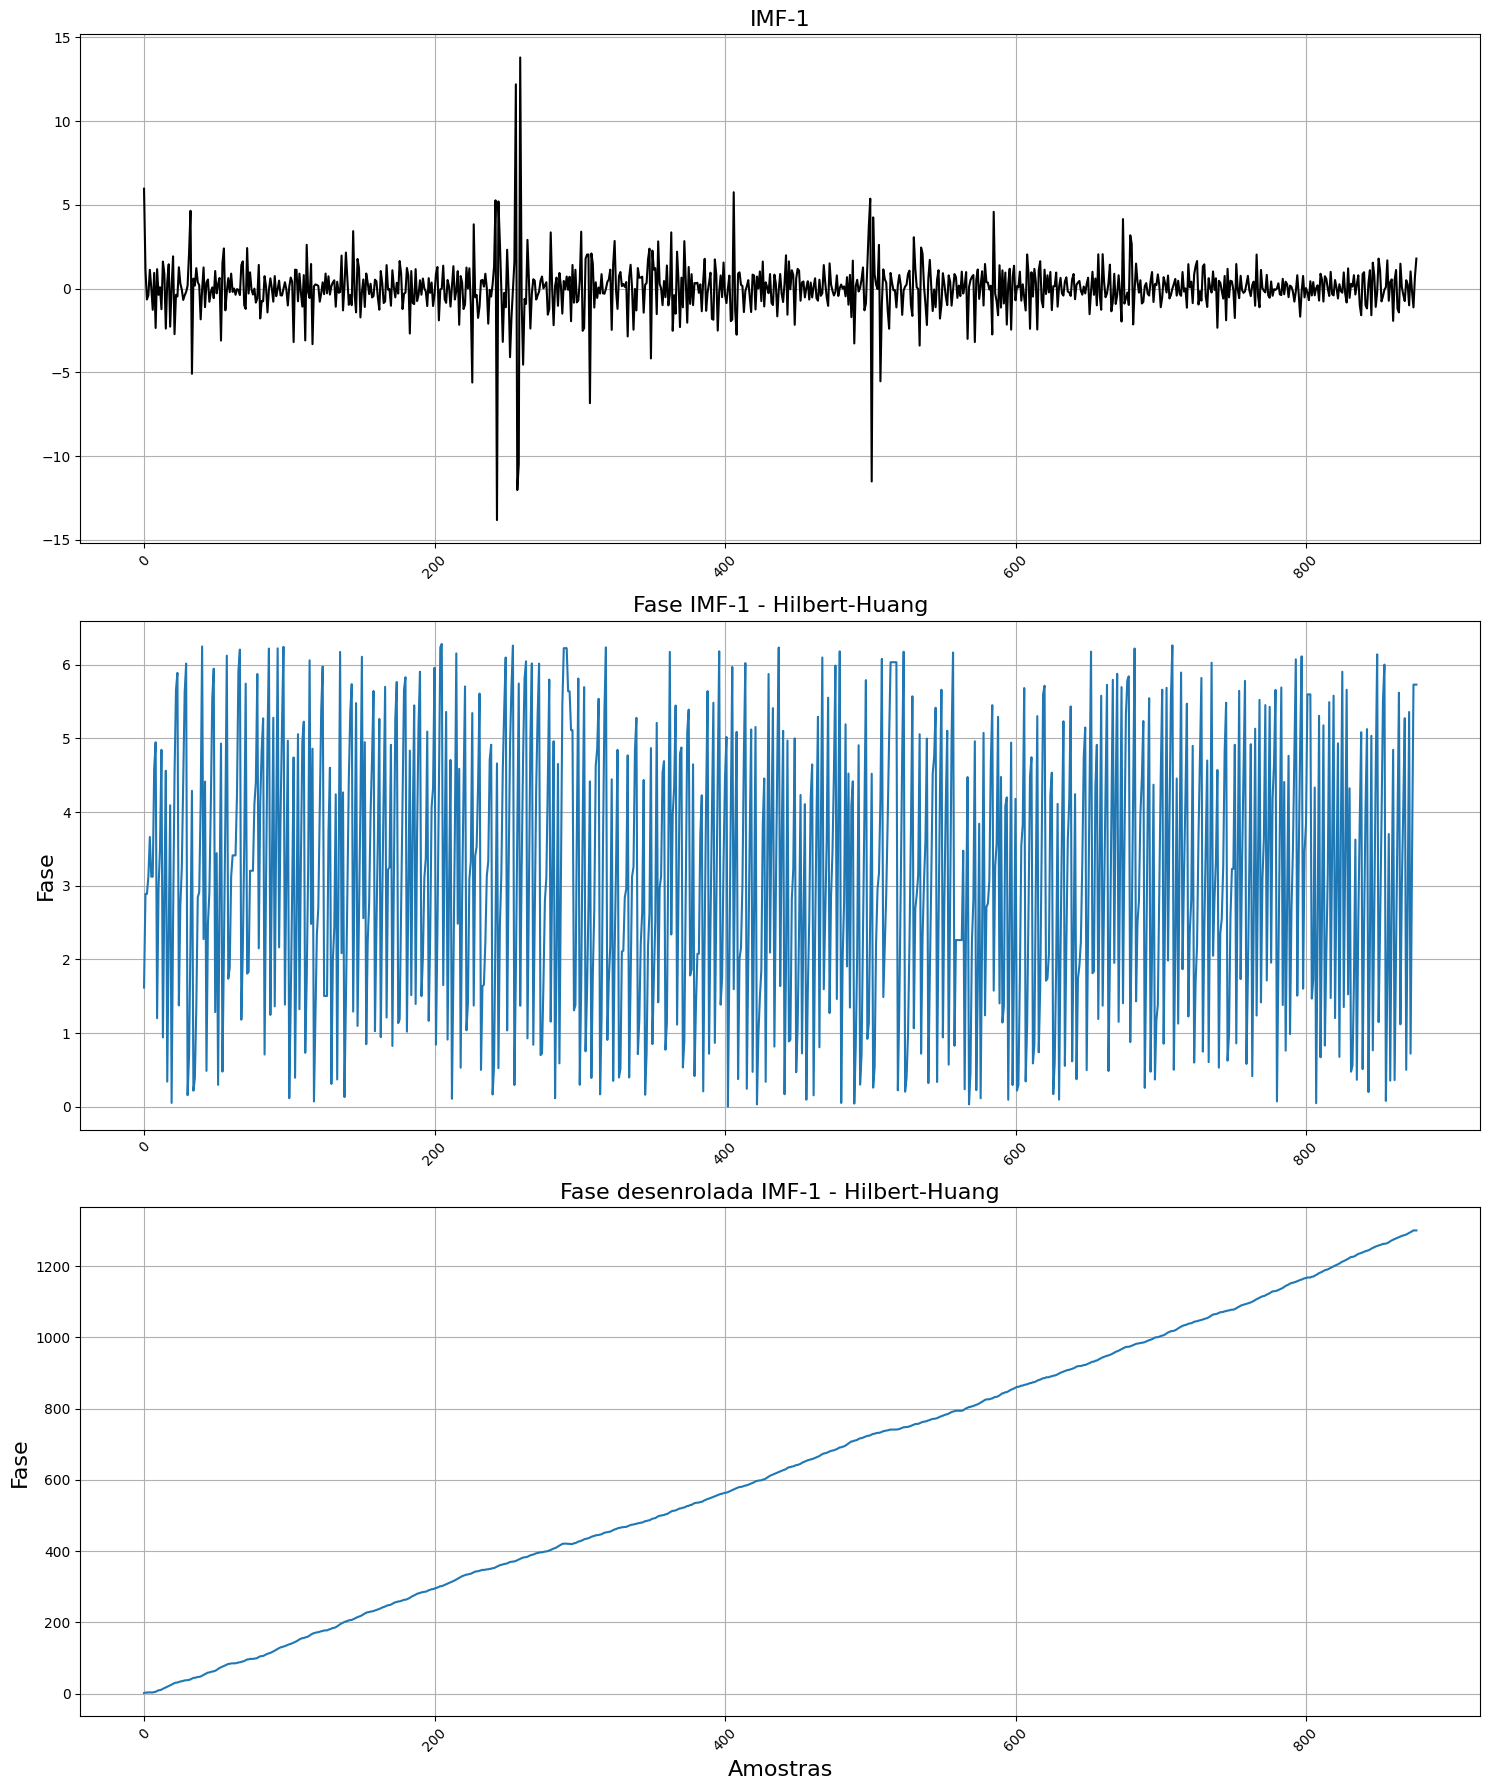

In [115]:
fase_preco_HH, fase_unwrapped_preco_HH = plot_fasesHH(precos, 0)

## Fourier - Preços

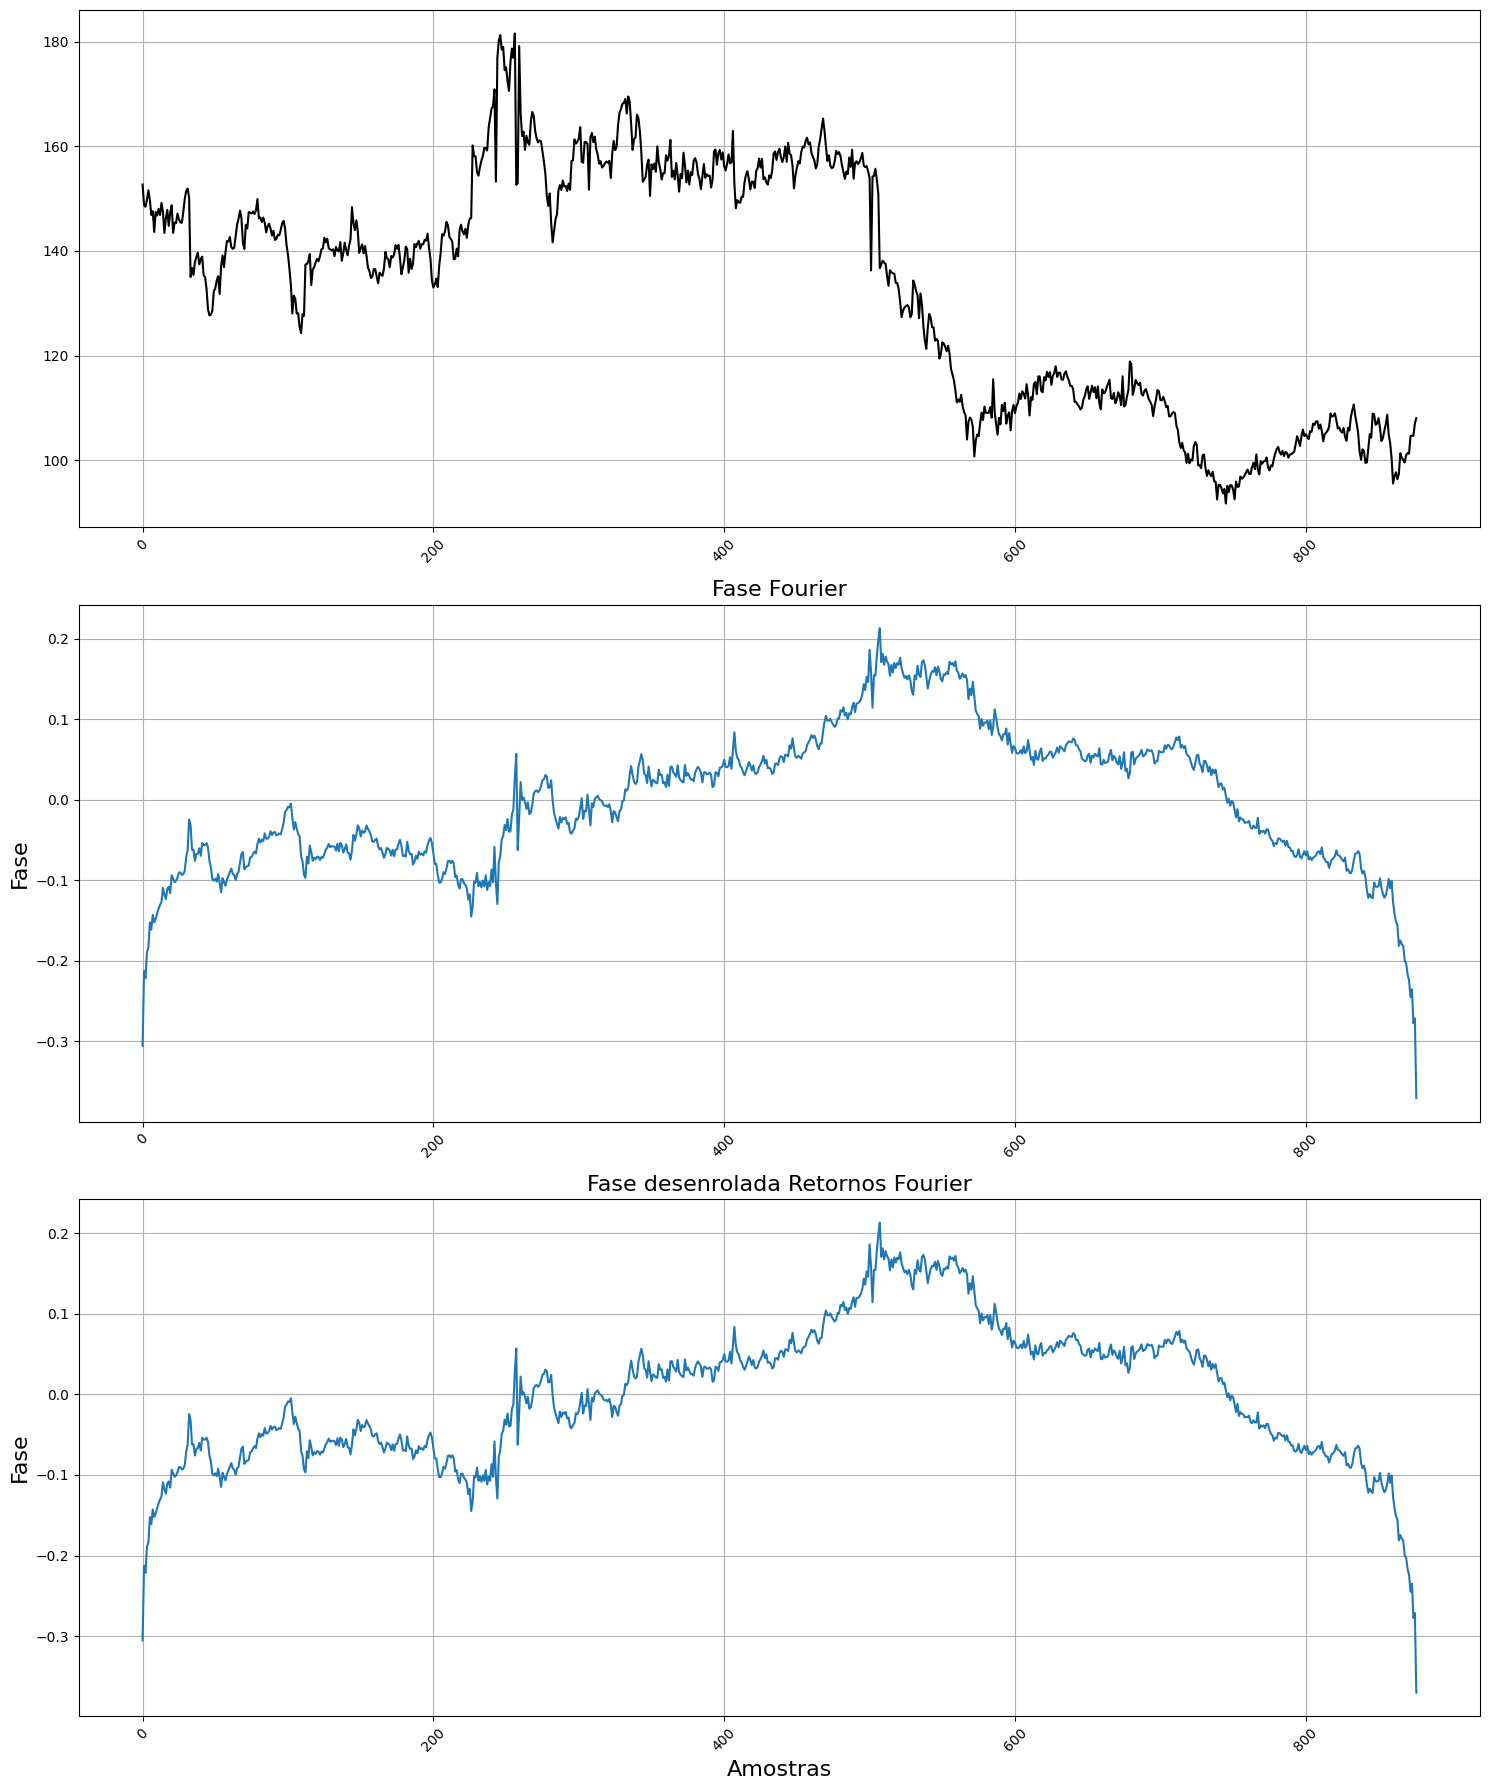

In [116]:
fase_preco_F, fase_unwrapped_preco_F = plot_fasesF(precos)

## Hilbert - Preços

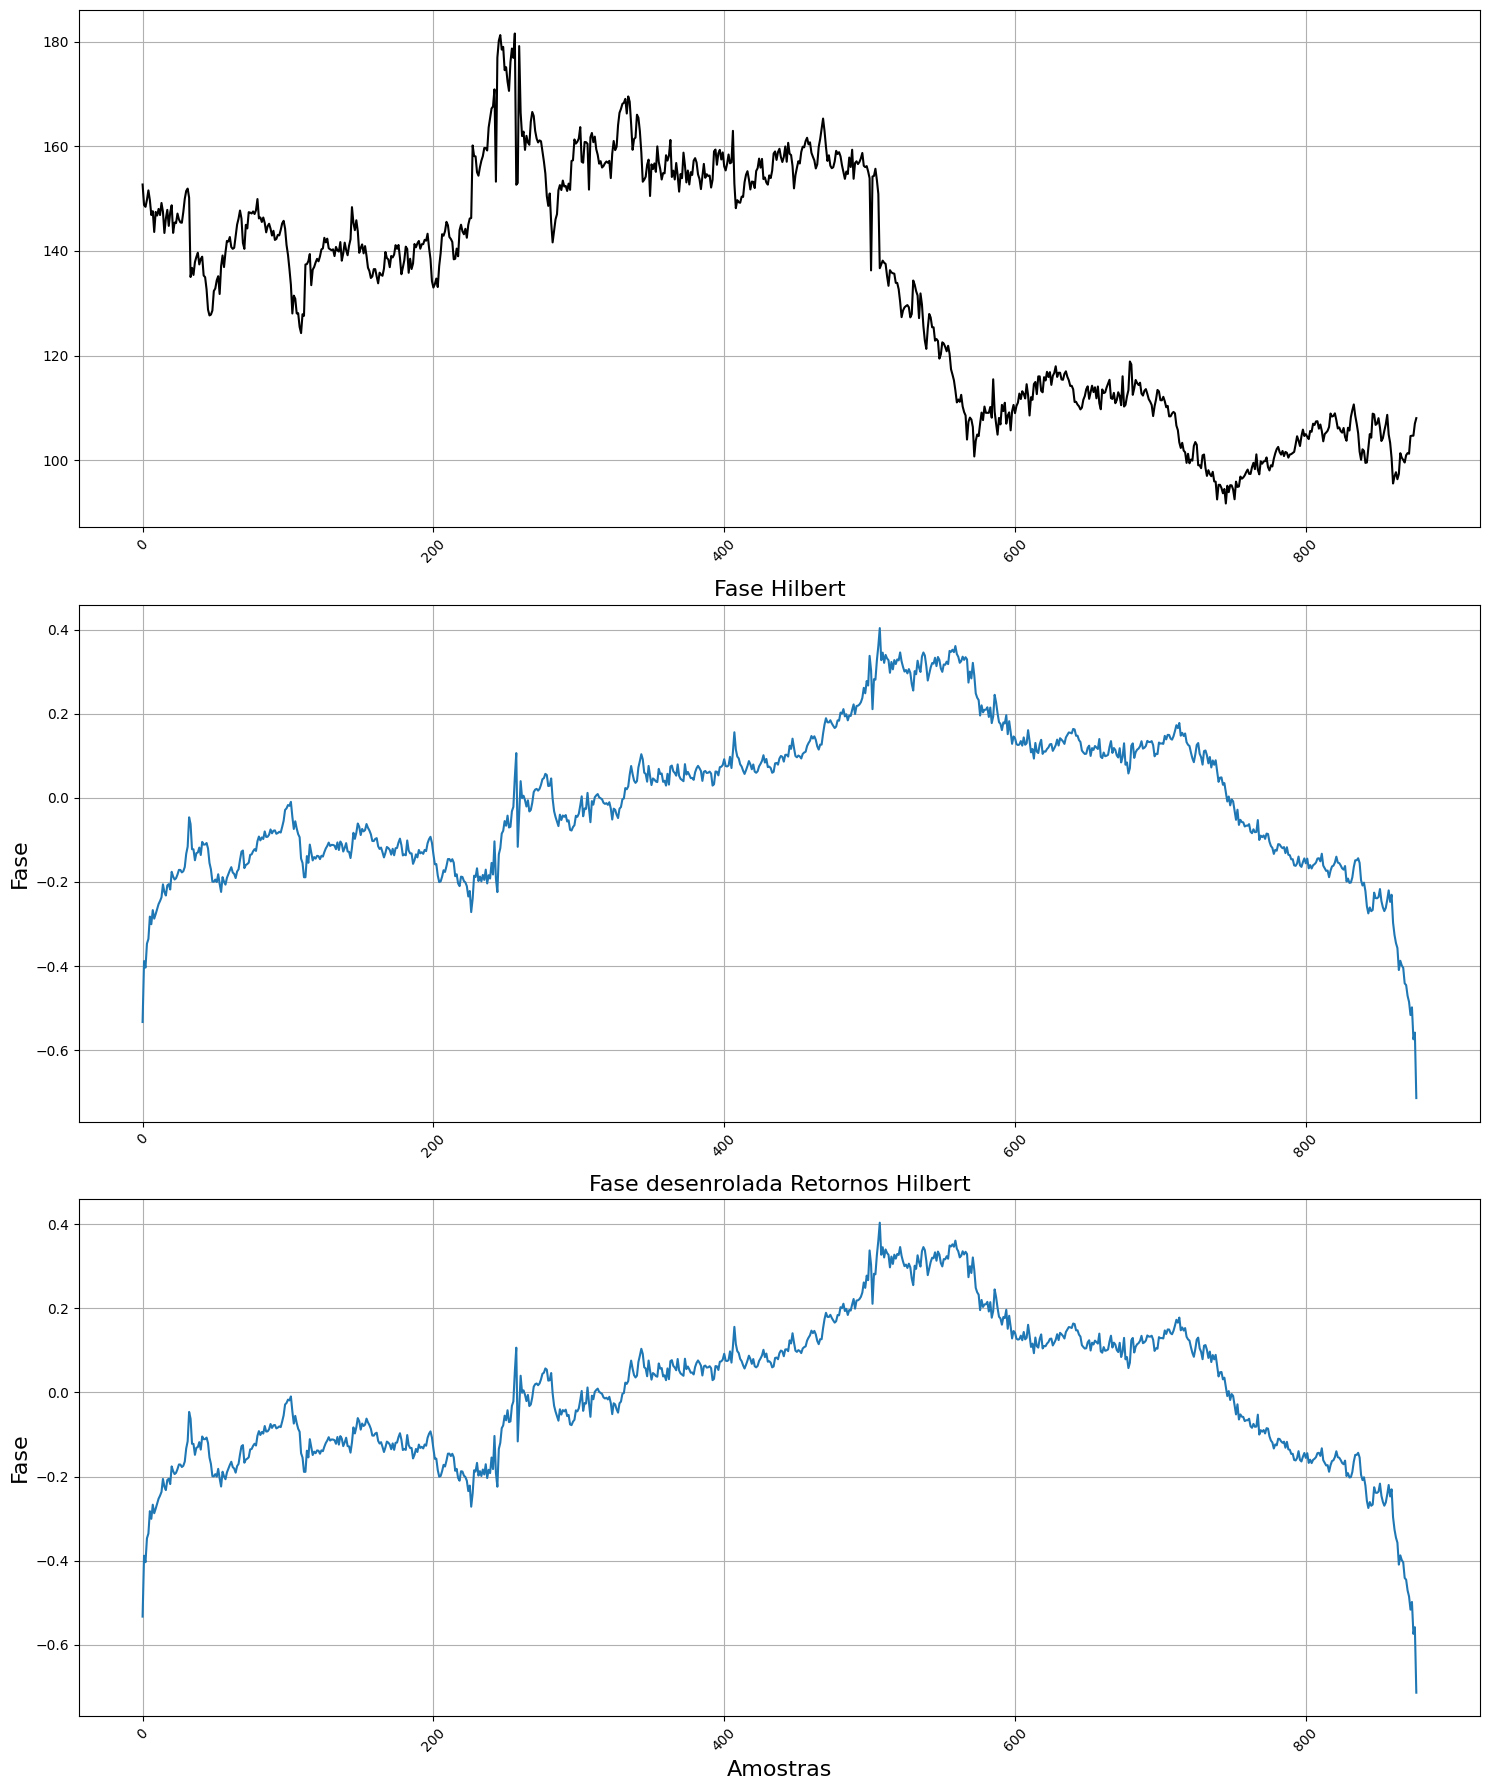

In [117]:
fase_preco_H, fase_unwrapped_preco_H = plot_fasesH(precos)

## Comparando as fases

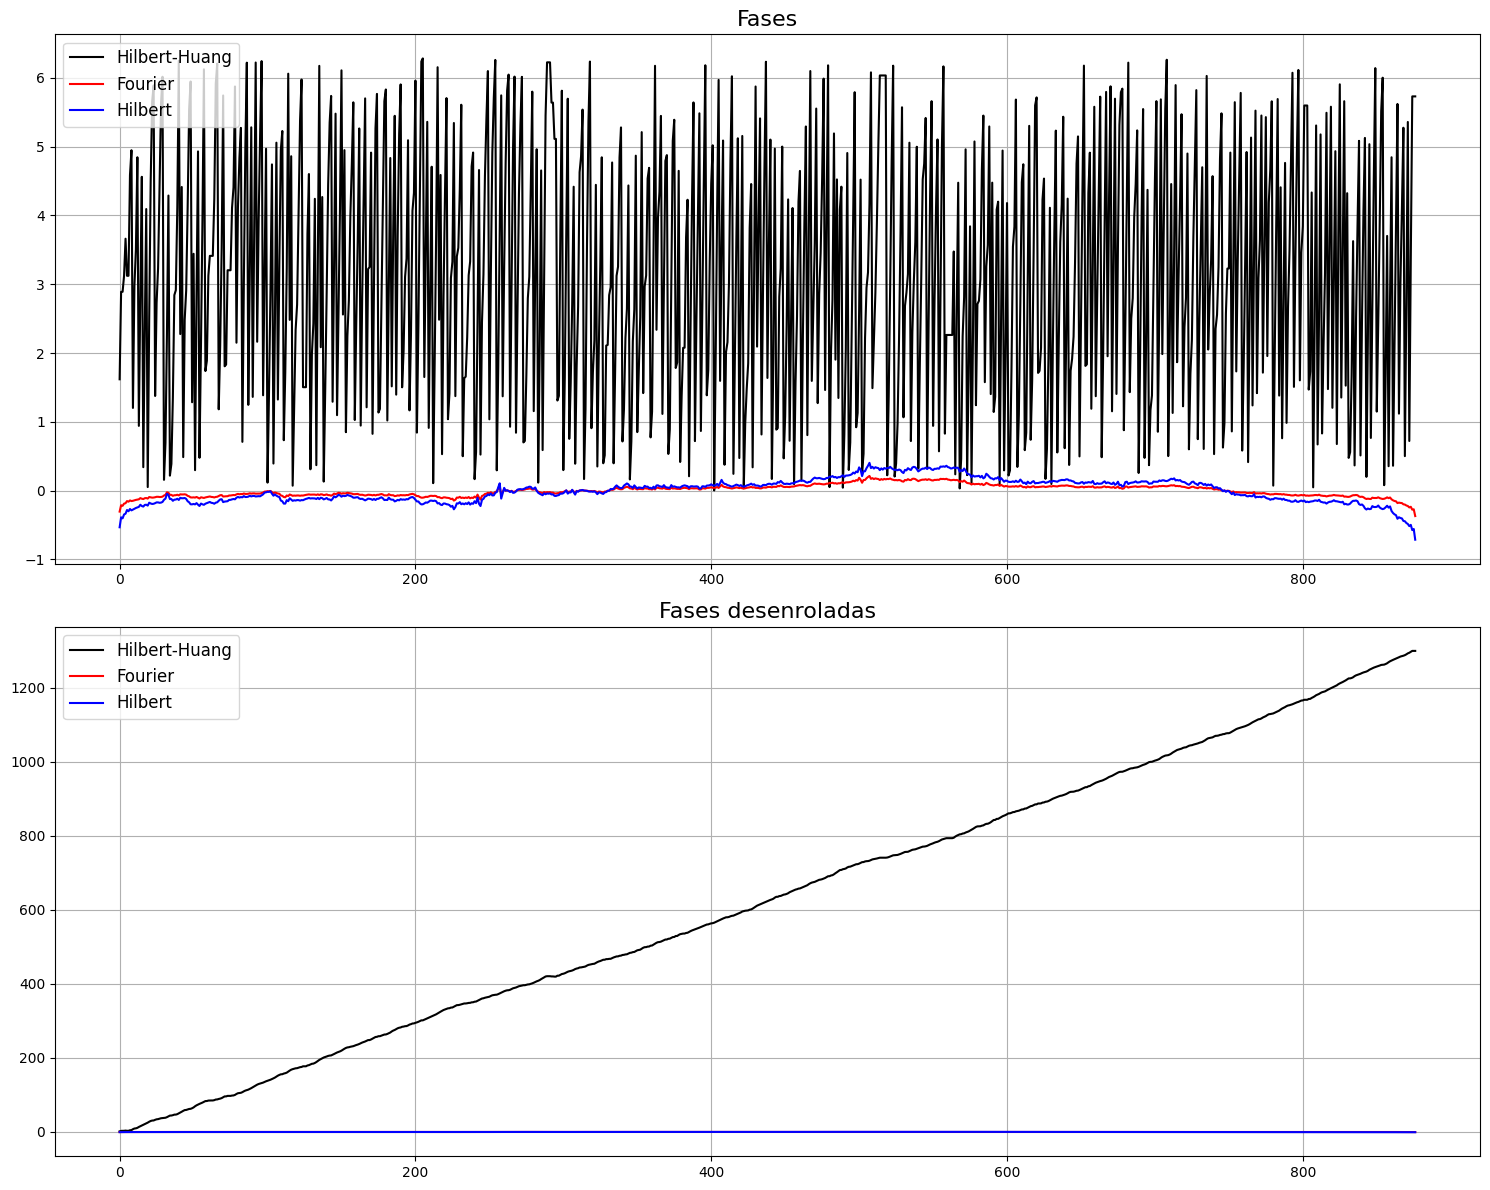

In [118]:
plot_ComparaFaseTransformadas(fase_preco_HH, 
                              fase_unwrapped_preco_HH, 
                              fase_preco_F, 
                              fase_unwrapped_preco_F, 
                              fase_preco_H, 
                              fase_unwrapped_preco_H)

# Observações

*   ### As fases de Fourier e Hilbert praticamente se sobrepoem, a diferença é melhor visualizada na versão desenrolada das fases.
*   ### Hilbert-Huang deixa o sinal mais estacionário, isso também é bem visualizado na fase desenrolada, a qual cresce de forma mais estável.